# Using the MCMC SMARTS model fit from Buildings
# to correct the spectrum of Vegetation

In [24]:
# -- importing necessary libraries

import os
import math
import numpy as np
import pandas as pd
import random
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import CustomJS, Div, ColumnDataSource
from bokeh.layouts import column, row
from bokeh.events import Tap
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import pysmarts
import emcee
import corner

In [2]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [3]:
# -- Function to call pySMARTS and produce a model

def modelFunc(scan, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
              W, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, TAU5):
    nalb = 111
    mywav = np.linspace(0.35,0.9,nalb)
    np.around(mywav, 2, mywav)
    albedo = albedoFunc(mywav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4)
    np.around(albedo, 4, albedo)
    
    if scan == '108':
        Year = 2016
        Month = 5
        Day = 5
        Hour = 14.02
    elif scan == '000':
        Year = 2016
        Month = 5
        Day = 2
        Hour = 17.77
    
    albwav = np.zeros(shape=(3000))
    albalb = np.zeros(shape=(3000))
    l = np.zeros(shape=(14,636))
    albwav[:nalb] = mywav
    albalb[:nalb] = albedo
    
    pymod = pysmarts.smarts295(W, ApCH2O, ApCH4, ApCO, ApHNO2, 
                               ApHNO3, ApNO, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, TAU5, 
                               1, 1, albwav, albalb, nalb, Year, Month, Day, Hour, l)
    
    return pymod[0], pymod[-2]

In [4]:
# -- Function to produce an albedo array

def albedoFunc(wav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4):
    albedo = (b1*np.exp(-((wav-a1)**2)/(2*(c1**2)))+d1) + \
             (b2*np.exp(-((wav-a2)**2)/(2*(c2**2)))+d2) + \
             (b3*np.exp(-((wav-a3)**2)/(2*(c3**2)))+d3) + \
             (b4*np.exp(-((wav-a4)**2)/(2*(c4**2)))+d4)
        
    return np.array(albedo)

In [5]:
# -- Function to interpolate the pySMARTS model into the cube's wavelengths
#    and multiply by the given amplitude

def interpModel(mywav, amp, modelwav, modelsmrt):
    interpMod = interp1d(modelwav, modelsmrt, fill_value="extrapolate")
    model = np.array(interpMod(mywav)) * amp
    
    return model

## Read Cube

In [6]:
# -- read the cube from .raw file into float array

fname = "../../../image_files/veg_00108.raw"
cube = read_hyper(fname)
cube_sub = cube.data[:, :, :].astype(float)

reading and parsing ../../../image_files/veg_00108.hdr...
reading ../../../image_files/veg_00108.raw...


In [7]:
## -- Plot cube
lam   = [610.,540.,475.]
bands = [np.arange(cube.waves.size)[(cube.waves>=(tlam-10.))&(cube.waves<(tlam+10.))] for tlam in lam]
red   = cube.data[bands[0]].mean(0)
grn   = cube.data[bands[1]].mean(0)
blu   = cube.data[bands[2]].mean(0)
red8  = red*2.**8/2.**12
grn8  = grn*2.**8/2.**12
blu8  = blu*2.**8/2.**12

In [8]:
wr    = red.mean()
wg    = grn.mean()
wb    = blu.mean()
scl   = np.array([wr,wg,wb])
scl  /= scl.max()
scl  /= np.array([0.9,1.0,1.0])
amp   = 1.0
rgb8  = (amp*np.dstack([red8,grn8,blu8])/scl).clip(0,255).astype(np.uint8)

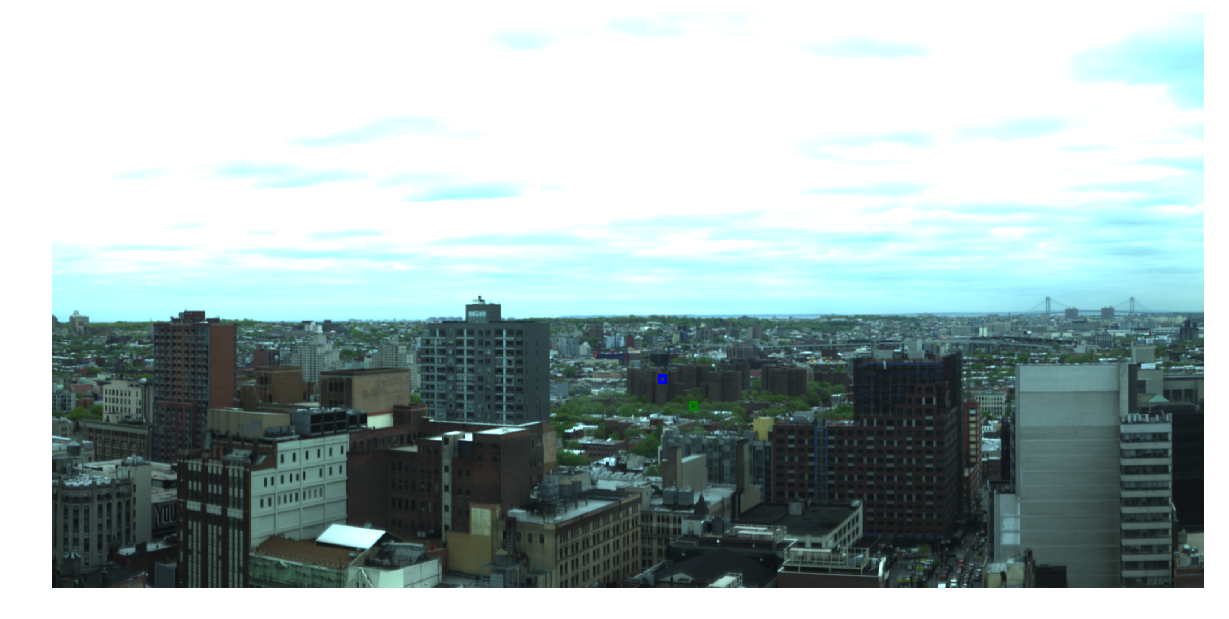

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline

brow = np.arange(1015,1020)
bcol = np.arange(847,852)

vrow = np.arange(1090,1095)
vcol = np.arange(890,895)

fig, ax = plt.subplots(figsize=[16,8])
fig.subplots_adjust(0.0,0.0,1.0,1.0)
ax.axis("off")
im = ax.imshow(rgb8,aspect=0.5,interpolation="nearest")
brect = patches.Rectangle((bcol[0], brow[0]), (bcol[1] - bcol[0]), (brow[1] - brow[0])*5, 
                          linewidth=8, edgecolor='blue', fill=False)
vrect = patches.Rectangle((vcol[0], vrow[0]), (vcol[1] - vcol[0]), (vrow[1] - vrow[0])*5, 
                          linewidth=8, edgecolor='green', fill=False)
ax.add_patch(brect)
ax.add_patch(vrect)
fig.canvas.draw()
fig.savefig("../output/scene_1a.png", dpi=300)
fig.savefig("../output/scene_1a.ps", dpi=300)

In [ ]:
rgba = np.pad(rgb8, [(0, 0), (0, 0), (0, 1)], mode='constant', constant_values=255.)
rgba = np.flip(rgba.astype(np.uint8), axis=0)

In [ ]:
# -- an interactive plot that shows the coordinates of mouse clicks

output_notebook()

def display_event(div, attributes=[], style = 'float:left;clear:left;font_size=10pt'):
    "Build a suitable CustomJS to display the current event in the div model."
    return CustomJS(args=dict(div=div), code="""
        var attrs = %s; var args = [];
        for (var i = 0; i<attrs.length; i++) {
            args.push(Number(cb_obj[attrs[i]]).toFixed(2));
        }
        var line = "<span style=%r>(" + args.join(", ") + ")</span>\\n";
        var text = div.text.concat(line);
        var lines = text.split("\\n")
        if (lines.length > 35)
            lines.shift();
        div.text = lines.join("\\n");
    """ % (attributes, style))
      

source_data = dict(image=[rgba],
                  x=[0],
                  y=[-1600],
                  dw=[1600],
                  dh=[1600])

p = figure(plot_width=800, plot_height=400, x_range=(0,1600), y_range=(-1600,0), tools=['pan','tap','box_zoom','wheel_zoom','save','reset'])
p.image_rgba(source=source_data, image='image', x='x', y='y', dw='dw', dh='dh')

div = Div(width=400, height=p.plot_height)
layout = row(p, div)

point_attributes = ['y', 'x']
p.js_on_event(Tap, display_event(div, attributes=point_attributes))

show(layout)

### Get building spectrum

(25, 2)


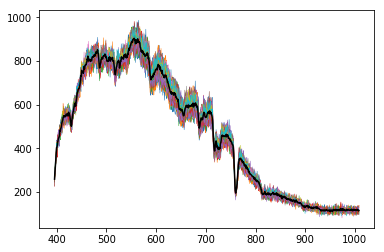

In [21]:
# -- choosing 5x5 pixels in building adjacent to vegetation
#    taking mean of spectra to use for fitting

brow = np.arange(1015,1020)
bcol = np.arange(847,852)
bcoords = np.vstack(np.meshgrid(brow, bcol)).reshape(2,-1).T
print(bcoords.shape)
for coord in bcoords:
    plt.plot(cube.waves, cube.data[:,coord[0],coord[1]], lw=0.5)
blds = cube.data[:,1015:1020,847:852].mean(axis=(1,2))
plt.plot(cube.waves, blds, color='black')
plt.show()

In [22]:
print(cube.waves[-200])

858.69


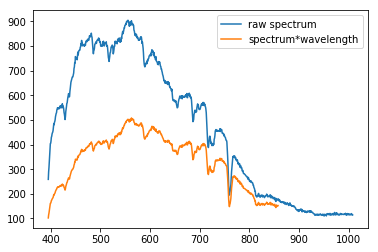

In [23]:
# -- multiplying mean building spectrum by wavelength
nwav = cube.waves[:-200]
nblds = blds*cube.waves/1e3
nblds = nblds[:-200]
plt.plot(cube.waves, blds, label='raw spectrum')
plt.plot(nwav, nblds, label='spectrum*wavelength')
plt.legend()
plt.show()

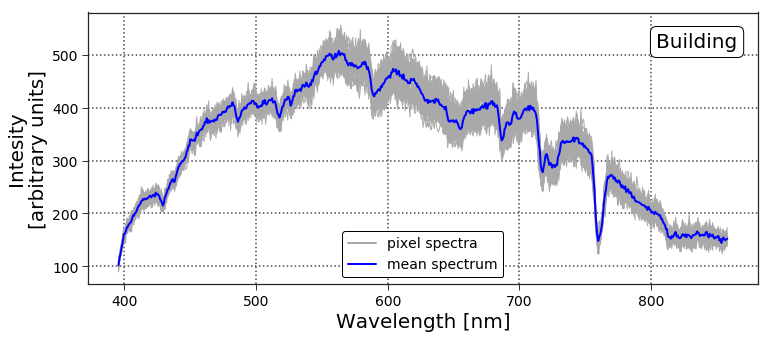

In [172]:
plt.style.use('seaborn-ticks')
plt.rcParams["axes.facecolor"]  = "w"
plt.rcParams["axes.grid"]       = True
plt.rcParams["axes.labelcolor"] = "k"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"]      = "#444444"
plt.rcParams["grid.linewidth"]  = 1.5
plt.rcParams["grid.linestyle"]  = ":"
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.color"]     = "k"
plt.rcParams["ytick.color"]     = "k"
plt.rcParams["text.color"]      = "k"
plt.rcParams["font.size"]       = 20
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

fig, ax = plt.subplots(figsize=(12,5))
for coord in bcoords:
    ax.plot(nwav, cube.data[:-200,coord[0],coord[1]]*nwav/1e3, lw=1, color='darkgrey')
ax.plot(nwav, cube.data[:-200,coord[0],coord[1]]*nwav/1e3, color='darkgrey', label='pixel spectra')
ax.plot(nwav, nblds, color='blue', label='mean spectrum')
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Intesity\n[arbitrary units]")
ax.legend(loc='lower center', frameon=True, edgecolor='black', framealpha=1, facecolor="white")
ax.annotate('Building', xy=(1,1), xycoords='axes fraction', xytext=(-20,-20), textcoords='offset points',
            ha='right', va='top', bbox=dict(boxstyle='round', fc="white"))
plt.show()
fig.savefig("../output/building_spectrum.png", dpi=300, bbox_inches='tight')
fig.savefig("../output/building_spectrum.ps", dpi=300, bbox_inches='tight')

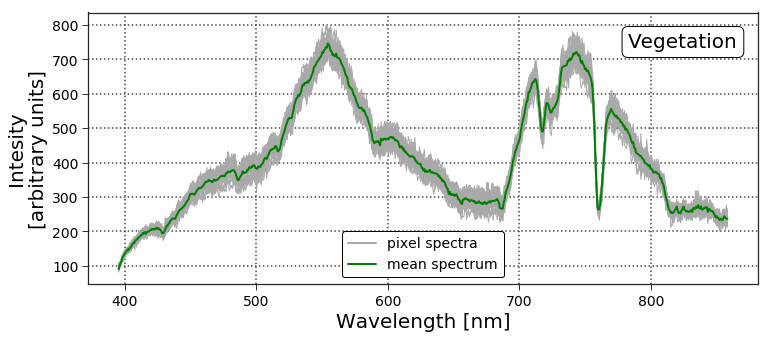

In [171]:
plt.style.use('seaborn-ticks')
plt.rcParams["axes.facecolor"]  = "w"
plt.rcParams["axes.grid"]       = True
plt.rcParams["axes.labelcolor"] = "k"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"]      = "#444444"
plt.rcParams["grid.linewidth"]  = 1.5
plt.rcParams["grid.linestyle"]  = ":"
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.color"]     = "k"
plt.rcParams["ytick.color"]     = "k"
plt.rcParams["text.color"]      = "k"
plt.rcParams["font.size"]       = 20
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

fig, ax = plt.subplots(figsize=(12,5))
for coord in vcoords:
    ax.plot(nwav, cube.data[:-200,coord[0],coord[1]]*nwav/1e3, lw=1, color='darkgrey')
ax.plot(nwav, cube.data[:-200,coord[0],coord[1]]*nwav/1e3, color='darkgrey', label='pixel spectra')
ax.plot(nwav, nveg, color='green', label='mean spectrum')
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Intesity\n[arbitrary units]")
ax.legend(loc='lower center', frameon=True, edgecolor='black', framealpha=1, facecolor="white")
ax.annotate('Vegetation', xy=(1,1), xycoords='axes fraction', xytext=(-20,-20), textcoords='offset points',
            ha='right', va='top', bbox=dict(boxstyle='round', fc="white"))
plt.show()
fig.savefig("../output/vegetation_spectrum.png", dpi=300, bbox_inches='tight')
fig.savefig("../output/vegetation_spectrum.ps", dpi=300, bbox_inches='tight')

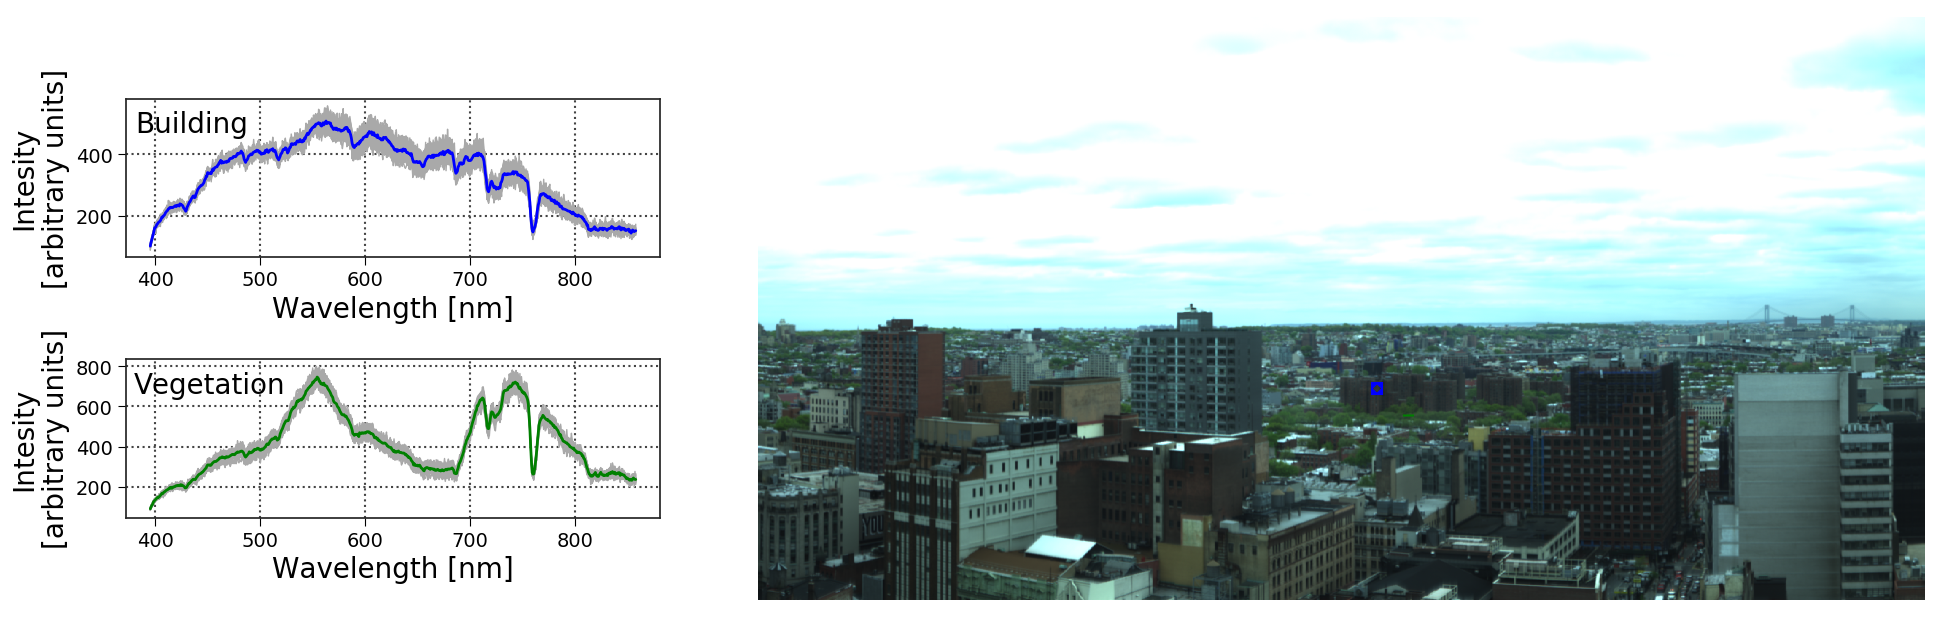

In [238]:
plt.style.use('seaborn-ticks')
plt.rcParams["axes.facecolor"]  = "w"
plt.rcParams["axes.grid"]       = True
plt.rcParams["axes.labelcolor"] = "k"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"]      = "#444444"
plt.rcParams["grid.linewidth"]  = 1.5
plt.rcParams["grid.linestyle"]  = ":"
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["xtick.color"]     = "k"
plt.rcParams["ytick.color"]     = "k"
plt.rcParams["text.color"]      = "k"
plt.rcParams["font.size"]       = 20
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

fig = plt.figure(figsize = (20,10))
fig.subplots_adjust(0.0,0.0,1.0,1.0)
ax1 = plt.subplot2grid((4,6), (0,2), rowspan=4, colspan=4)
ax2 = plt.subplot2grid((4,6), (1,0), colspan=2, rowspan=1)
ax3 = plt.subplot2grid((4,6), (2,0), colspan=2, rowspan=1)

ax1.axis("off")
im = ax1.imshow(rgb8,aspect=0.5,interpolation="nearest")
brect = patches.Rectangle((bcol[0], brow[0]), (bcol[1] - bcol[0]), (brow[1] - brow[0])*5, 
                          linewidth=8, edgecolor='blue', fill=False)
vrect = patches.Rectangle((vcol[0], vrow[0]), (vcol[1] - vcol[0]), (vrow[1] - vrow[0])*5, 
                          linewidth=8, edgecolor='green', fill=False)
ax1.add_patch(brect)
ax1.add_patch(vrect)
ax1.tick_params(axis='both', which="both", bottom=False, top=False)

for coord in bcoords:
    ax2.plot(nwav, cube.data[:-200,coord[0],coord[1]]*nwav/1e3, lw=1, color='darkgrey')
#ax2.plot(nwav, cube.data[:-200,coord[0],coord[1]]*nwav/1e3, color='darkgrey', label='pixel spectra')
ax2.plot(nwav, nblds, color='blue', label='mean spectrum')
ax2.set_xlabel("Wavelength [nm]")
ax2.set_ylabel("Intesity\n[arbitrary units]")
#ax2.legend(loc='lower center', frameon=True, edgecolor='black', framealpha=1, facecolor="white")
ax2.annotate('Building', xy=(0.28,1.1), xycoords='axes fraction', xytext=(-20,-20), textcoords='offset points',
            ha='right', va='top')

for coord in vcoords:
    ax3.plot(nwav, cube.data[:-200,coord[0],coord[1]]*nwav/1e3, lw=1, color='darkgrey')
#ax3.plot(nwav, cube.data[:-200,coord[0],coord[1]]*nwav/1e3, color='darkgrey', label='pixel spectra')
ax3.plot(nwav, nveg, color='green', label='mean spectrum')
ax3.set_xlabel("Wavelength [nm]")
ax3.set_ylabel("Intesity\n[arbitrary units]")
#ax3.legend(loc='lower center', frameon=True, edgecolor='black', framealpha=1, facecolor="white")
ax3.annotate('Vegetation', xy=(0.35,1.1), xycoords='axes fraction', xytext=(-20,-20), textcoords='offset points',
            ha='right', va='top')
plt.tight_layout()
plt.show()
fig.savefig("../output/scene_1_a_spectra.png", dpi=300, bbox_inches='tight')
fig.savefig("../output/scene_1_a_spectra.ps", dpi=300, bbox_inches='tight')

## Model tests

In [20]:
a1 = 0.62
b1 = 0.159
c1 = 0.114
d1 = 0.10

a2 = 0.755
b2 = 0.0748
c2 = 0.045
d2 = -0.01

a3 = 1.9
b3 = 0.111
c3 = 1.049
d3 = 0.0001

a4 = 0.584
b4 = 0.07
c4 = 0.11
d4 = 0.0001

W = 2.0
ApCH2O = 0.0007
ApCH4 = 0.03
ApCO = 0.035
ApHNO2 = 0.0002
ApHNO3 = 0.0005
ApNO = 0.02
ApNO2 = 0.002
ApNO3 = 5e-6
AbO3 = 0.33
ApO3 = 0.0053
ApSO2 = 0.005

qCO2 = 370.0
TAU5 = 0.084
    
amp = 1999.5
eps = 18.5
    
amp = 2052
eps = 21.1

In [21]:
## -- Model time

import time
start_time = time.time()
for i in np.arange(100):
    smrtwav, smrtmod = modelFunc('108', a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                               W, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, TAU5)
    tmodel = interpModel(nwav, amp, smrtwav, smrtmod)

elapsed_time = time.time() - start_time
print(elapsed_time/100)

0.023988730907440185


### Test O3 concentration

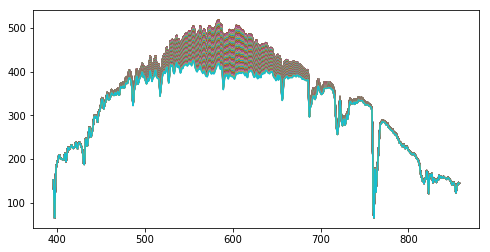

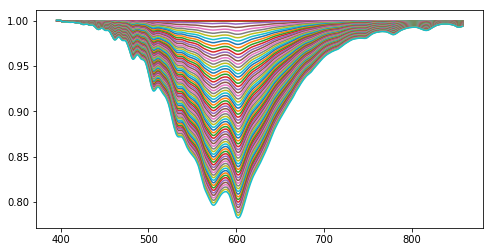

In [58]:
O3model = []
for O3 in np.linspace(-0.99, 0.99, 100):
    ApO3 = O3
    smrtwav, smrtmod = modelFunc('108', a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                               W, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, TAU5)
    O3model.append(interpModel(nwav, amp, smrtwav, smrtmod))

plt.figure(figsize=(8,4))
for ii in O3model:
    plt.plot(nwav, ii)
plt.show()

plt.figure(figsize=(8,4))
for ii in O3model:
    plt.plot(nwav, ii/O3model[0])
plt.show()

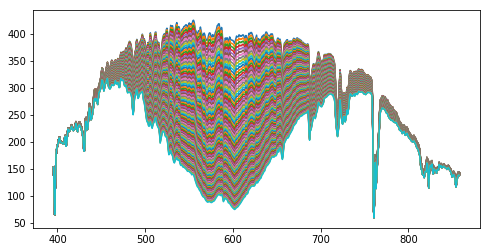

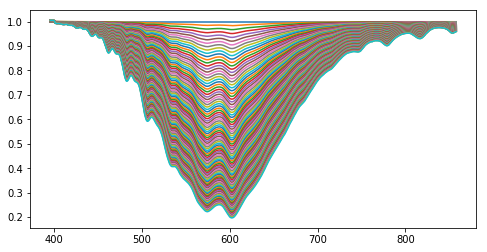

In [59]:
O3model = []
for O3 in np.linspace(1.0, 10.0, 100):
    ApO3 = O3
    smrtwav, smrtmod = modelFunc('108', a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                               W, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, TAU5)
    O3model.append(interpModel(nwav, amp, smrtwav, smrtmod))

plt.figure(figsize=(8,4))
for ii in O3model:
    plt.plot(nwav, ii)
plt.show()

plt.figure(figsize=(8,4))
for ii in O3model:
    plt.plot(nwav, ii/O3model[0])
plt.show()

### Test TAU5

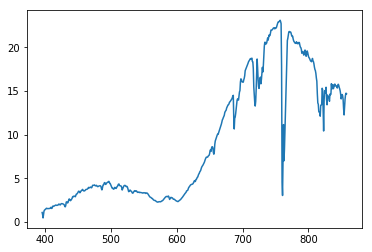

In [60]:
smrtwav, smrtmod = modelFunc('108', a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                               W, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, 5.57028222084)
tmodel = interpModel(nwav, amp, smrtwav, smrtmod)

plt.plot(nwav, tmodel)

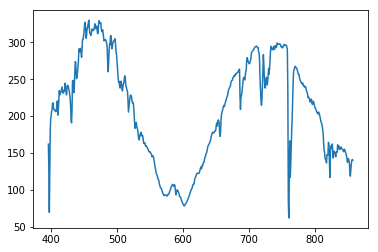

In [66]:
smrtwav, smrtmod = modelFunc('108', a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                               W, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, 0.0)
tmodel = interpModel(nwav, amp, smrtwav, smrtmod)

plt.plot(nwav, tmodel)

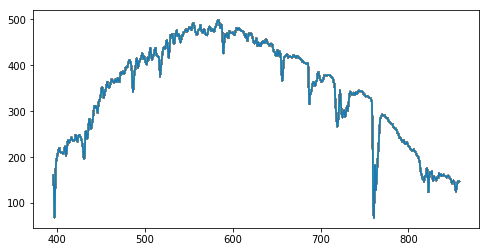

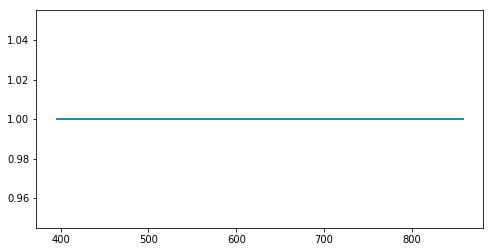

In [68]:
T5model = []
ApO3 = 0.053
for Tau5 in np.linspace(-100.0, 0.0, 101):
    smrtwav, smrtmod = modelFunc('108', a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                  W, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, Tau5)
    T5model.append(interpModel(nwav, amp, smrtwav, smrtmod))

plt.figure(figsize=(8,4))
for ii in T5model:
    plt.plot(nwav, ii)
plt.show()

plt.figure(figsize=(8,4))
for ii in T5model:
    plt.plot(nwav, ii/T5model[0])
plt.show()

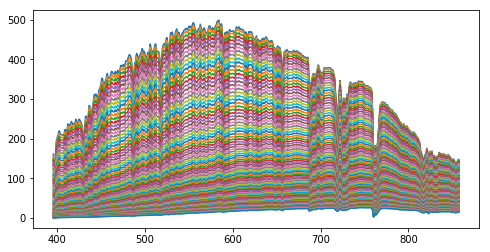

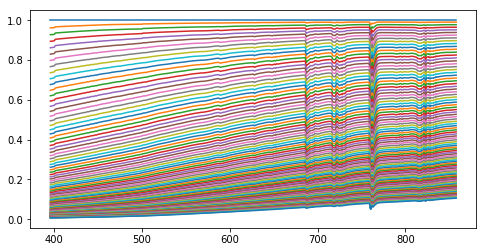

In [69]:
T5model = []
ApO3 = 0.053
for Tau5 in np.linspace(0.0, 5.57028222084, 101):
    smrtwav, smrtmod = modelFunc('108', a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3, a4, b4, c4, d4,
                   W, ApCH2O, ApHNO2, ApHNO3, ApNO2, ApNO3, AbO3, ApO3, ApSO2, qCO2, Tau5)
    T5model.append(interpModel(nwav, amp, smrtwav, smrtmod))

plt.figure(figsize=(8,4))
for ii in T5model:
    plt.plot(nwav, ii)
plt.show()

plt.figure(figsize=(8,4))
for ii in T5model:
    plt.plot(nwav, ii/T5model[0])
plt.show()

## Reading Building MCMC samples

In [10]:
filename = "MCMC_108.h5"
if not os.path.isfile(filename):
    print('Filename {0} does not exist'.format(filename))
else:
    backend = emcee.backends.HDFBackend(filename, read_only=True)
    nwalkers, ndim = 200, 27
    nsteps = backend.iteration
    print("   number of walkers    = ", nwalkers)
    print("   number of dimensions = ", ndim)
    print("   number of steps      = ", nsteps)

   number of walkers    =  200
   number of dimensions =  27
   number of steps      =  500000


In [11]:
# -- Calculate tau
tau = backend.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10000;
tau: [53497.74350858 55650.1660891  53238.68080305 51958.70550678
 46415.8708016  49727.5617128  45622.63465386 52166.486834
 49846.56559018 62821.23764924 56942.33673468 51304.77518545
 42120.5608832  49670.94969022 26373.47681233 53101.76872425
 42877.7268483  52984.11268183 57490.51130514 59436.03244951
 46562.67360003 59322.18596356 45534.64688338 45027.28640332
 45439.45643076 51535.59756227 43740.39490024]

In [92]:
burnin = 60000
thin = 10000
samples = backend.get_chain(discard=burnin, thin=thin, flat=True)
print("   burn-in = ", burnin)
print("   thin = ", thin)
print("   flat chain shape: ", samples.shape)

   burn-in =  60000
   thin =  10000
   flat chain shape:  (2800, 27)


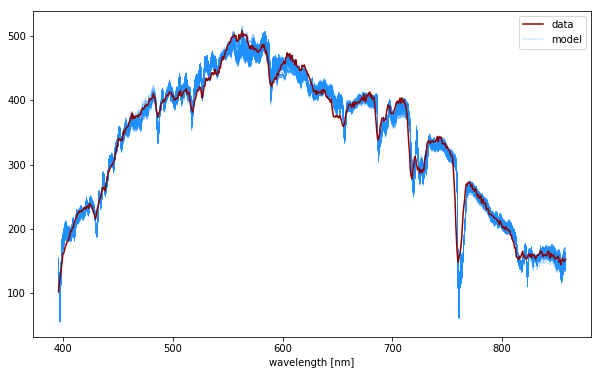

In [93]:
# -- Plot a sample of the MCMC solutions
scan = '108'

fig, ax = plt.subplots(figsize=(10,6))
inds = np.random.randint(len(samples), size=800)
for ind in inds:
    sample = samples[ind]
    smrtwav, smrtmod = modelFunc(scan, *sample[:-2])
    maxmod = interpModel(nwav, sample[-2], smrtwav, smrtmod)
    linm, = ax.plot(nwav, maxmod, color='dodgerblue', lw=0.3)
linb, = ax.plot(nwav, nblds, color='darkred')
ax.set_xlabel('wavelength [nm]')
ax.legend([linb, linm], ['data', 'model'])
plt.show()

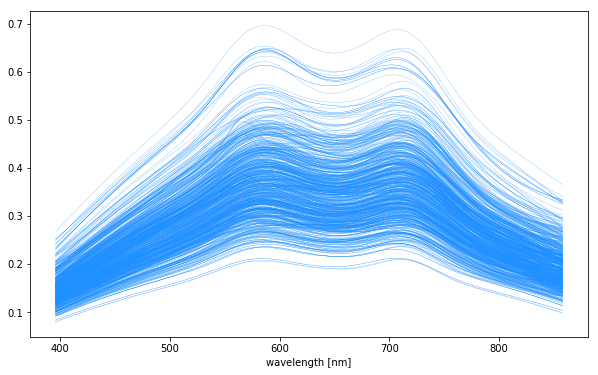

In [94]:
fig, ax = plt.subplots(figsize=(10,6))
inds = np.random.randint(len(samples), size=800)
for ind in inds:
    sample = samples[ind]
    albedo = albedoFunc(nwav/1000., *sample[:16])
    linm, = ax.plot(nwav, albedo, color='dodgerblue', lw=0.2)
ax.set_xlabel('wavelength [nm]')
plt.show()

In [95]:
# -- Dividing samples by their albedos 
#    to get incident*absorption spectra

atmospec = np.zeros(shape=(samples.shape[0], len(nwav)))
for ind in np.arange(samples.shape[0]):
    smrtwav, smrtmod  = modelFunc(scan, *samples[ind,:-2])
    model = interpModel(nwav, samples[ind,-2], smrtwav, smrtmod)
    albedo = albedoFunc(nwav/1000., *samples[ind,:16])
    
    atmospec[ind] = model/albedo

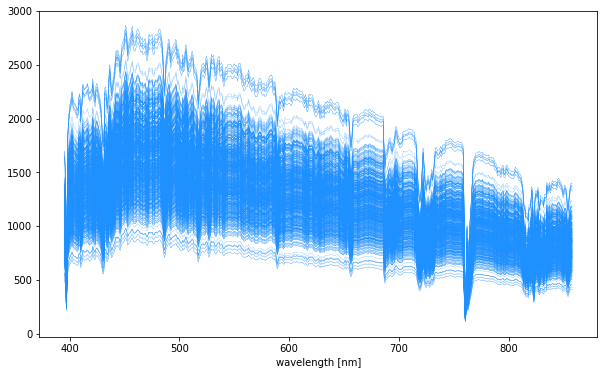

In [96]:
fig, ax = plt.subplots(figsize=(10,6))
inds = np.random.randint(len(bldspec), size=800)
for ind in inds:
    sample = atmospec[ind]
    linm, = ax.plot(nwav, sample, color='dodgerblue', lw=0.2)
ax.set_xlabel('wavelength [nm]')
plt.show()

### get vegetation spectrum

(25, 2)


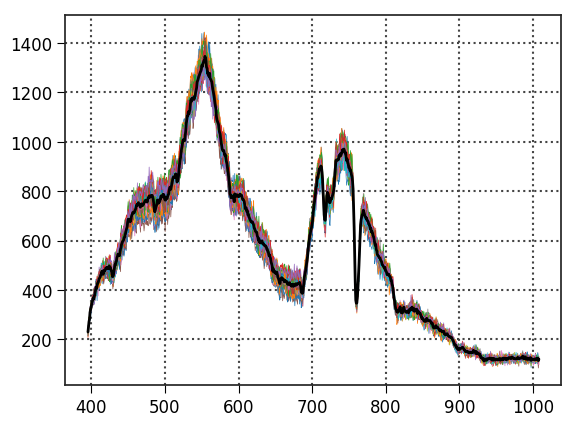

In [119]:
vrow = np.arange(1090,1095)
vcol = np.arange(890,895)
vcoords = np.vstack(np.meshgrid(vrow, vcol)).reshape(2,-1).T
print(vcoords.shape)
for coord in vcoords:
    plt.plot(cube.waves, cube.data[:,coord[0],coord[1]], lw=0.5)
veg = cube.data[:,1090:1095,890:895].mean(axis=(1,2))
plt.plot(cube.waves, veg, color='black')
plt.show()

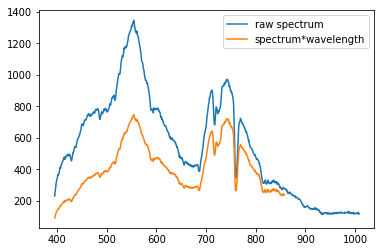

In [14]:
# -- multiplying mean building spectrum by wavelength
nveg = veg*cube.waves/1e3
nveg = nveg[:-200]
plt.plot(cube.waves, veg, label='raw spectrum')
plt.plot(nwav, nveg, label='spectrum*wavelength')
plt.legend()
plt.show()

### Correct Vegetation spectra for atmosphere

In [99]:
# -- divide veg spectra by the atmosphere

vegspec = np.zeros(shape=(samples.shape[0], len(nwav)))
for ind in np.arange(samples.shape[0]):
    vegspec[ind] = nveg/atmospec[ind]

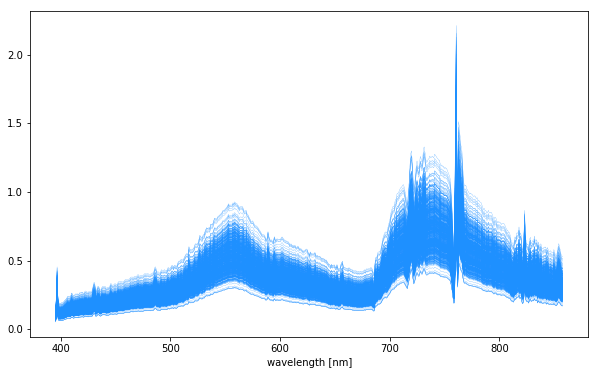

In [100]:
fig, ax = plt.subplots(figsize=(10,6))
inds = np.random.randint(len(bldspec), size=800)
for ind in inds:
    sample = vegspec[ind]
    linm, = ax.plot(nwav, sample, color='dodgerblue', lw=0.2)
ax.set_xlabel('wavelength [nm]')
plt.show()

## Least Squares Fit

In [ ]:
## -- using least squares fit to find best parameters
from scipy.interpolate import interp1d

def func(wav, W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, ApO3, ApSO2,
                qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, IALBDX, Ialbdg,amp):
    l = np.zeros(shape=(14,636))
    c = np.zeros(shape=(6,851))
    
    TAIR = 15.5
    RH = 69.0
    TDAY = 12.5
    #IALBDX = 18
    #Ialbdg = 18
    Year = 2016
    Month = 5
    Day = 5
    Hour = 14.02
    
    l,c = pysmarts.smarts295(TAIR,RH,TDAY, W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, 
                             ApHNO3, ApNO, ApNO2, ApNO3, ApO3, ApSO2, qCO2, 
                             ALPHA1, ALPHA2, OMEGL, GG, TAU5, int(IALBDX), int(Ialbdg),
                             Year, Month, Day, Hour,l,c)
    
    interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
    model = interp_l(wav)
    
    return model*amp

In [ ]:
from scipy.optimize import curve_fit

popt, popcov = curve_fit(func, cube.waves, blds*cube.waves/1e3, p0=(12.0,0.35,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                                                     5e-5,0.053,0.05,370.0,0.9111,1.3529,0.8,0.7,0.084,
                                                     18,18,2200), 
                         bounds=([0.,.2,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,350.,0.,0.,.6,.5,0.,2,2,0.],
                                 [12.,.5,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,400.,2.6,2.6,1.,.9,.5,66,66,10000.]))

In [ ]:
popt

In [ ]:
#plt.plot(cube.waves, blds*cube.waves/1e3, color='black', label='Mean Building Spectrum (*wavelength)')
plt.plot(cube.waves, myl, label='Model')

## MCMC

In [ ]:
from scipy.interpolate import interp1d

def func(wav, W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, ApO3, ApSO2,
                qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5):
    l = np.zeros(shape=(14,636))
    c = np.zeros(shape=(6,851))
    
    TAIR = 15.5
    RH = 69.0
    TDAY = 12.5
    IALBDX = 18
    Ialbdg = 18
    Year = 2016
    Month = 5
    Day = 5
    Hour = 14.02
    
    l,c = pysmarts.smarts295(TAIR,RH,TDAY, W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, 
                             ApHNO3, ApNO, ApNO2, ApNO3, ApO3, ApSO2, qCO2, 
                             ALPHA1, ALPHA2, OMEGL, GG, TAU5, int(IALBDX), int(Ialbdg),
                             Year, Month, Day, Hour,l,c)
    
    interp_c = interp1d(c[0], c[5], fill_value="extrapolate")
    model = interp_c(wav)
    
    return model*1000.

In [ ]:
def log_prior(theta):
    W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, ApO3, \
    ApSO2, qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, offset, eps = theta
    if ((W > 12) or 
        (AbO3 < 0.1) or (AbO3 > 0.6) or 
        (ApCH2O < 0) or (ApCH2O > 2.0) or 
        (ApCH4 < 0) or (ApCH4 > 2.0) or 
        (ApCO < 0) or (ApCO > 2.0) or 
        (ApHNO2 < 0) or (ApHNO2 > 2.0) or
        (ApHNO3 < 0) or (ApHNO3 > 2.0) or
        (ApNO < 0) or (ApNO > 2.0) or
        (ApNO2 < 0) or (ApNO2 > 2.0) or
        (ApNO3 < 0) or (ApNO3 > 2.0) or
        (ApO3 < 0) or (ApO3 > 2.0) or
        (ApSO2 < 0) or (ApSO2 > 2.0) or
        (qCO2 < 350) or (qCO2 > 450) or
        (ALPHA1 < 0) or (ALPHA1 > 2.7) or
        (ALPHA1 < 0) or (ALPHA2 > 2.7) or
        (OMEGL < 0.5) or (OMEGL > 1.0) or
        (GG < 0.4) or (GG > 1.0) or
        (TAU5 < 0) or (TAU5 > 1.0) or
        (eps <= 0)):
        return -np.inf
    return 0.0

def log_likelihood(theta, wav, y):
    W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, ApNO3, ApO3, \
    ApSO2, qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5, offset, eps = theta
    model = func(wav, W, AbO3, ApCH2O, ApCH4, ApCO, ApHNO2, ApHNO3, ApNO, ApNO2, 
                 ApNO3, ApO3, ApSO2,qCO2, ALPHA1, ALPHA2, OMEGL, GG, TAU5) + offset
    denom = eps**2
    lp = -0.5 * sum(((y-model)**2) / denom + np.log(denom) + np.log(2*np.pi))
    return lp

def log_probability(theta, wav, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, wav, y)

In [ ]:
## -- Maximum Likelihood function
from scipy.optimize import minimize

def MaxLikFunc(blds, wav, random_seed=314):
    np.random.seed(random_seed)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,5e-5,0.053,0.05,
                        370.0,0.9111,1.3529,0.8,0.7,0.084,0.0,1.0])
    result = minimize(nll, initial, args=(wav, blds))
    
    return result

In [ ]:
print("Maximum Likelihood results:")

import time
start_time = time.time()
result = MaxLikFunc(blds, cube.waves, random_seed=123)
elapsed_time = time.time() - start_time
print(result.x)
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
plt.plot(cube.waves, blds, color='black', label='Mean Building Spectrum')
plt.plot(cube.waves, func(cube.waves, *result.x[:-2])+result.x[-2], label='model')
plt.title('Maximum Likelihood')
plt.legend()
plt.show()

In [ ]:
nwalkers, ndim = 50, 20
p0 = 

## Looking at Sky Spectra

In [ ]:
srow = np.arange(795,800)
scol = np.arange(847,852)
scoords = np.vstack(np.meshgrid(srow, scol)).reshape(2,-1).T
print(scoords.shape)
for coord in scoords:
    plt.plot(cube.waves, cube.data[:,coord[0],coord[1]], lw=0.5)
sky = cube.data[:,795:800,847:852].mean(axis=(1,2))
plt.plot(cube.waves, sky, color='blue')
plt.show()

In [ ]:
fig = plt.subplots(figsize=(15,8))
i=1
for label in llabels:
    plt.plot(l[0], l[i]*3000, label=label)
    i=i+1
plt.plot(cube.waves, sky, color='black', label='Mean Building Spectrum')
plt.legend()
#plt.ylim(0,3000)
plt.show()

In [ ]:
fig = plt.subplots(figsize=(10,6))
plt.plot(l1[0], l1[8]*5000, label='low water')
plt.plot(l2[0], l2[8]*5000, label='high water')
plt.plot(cube.waves, sky, color='black', label='Mean Building Spectrum')
plt.legend()
plt.title(clabels[4])
plt.show()

## Vegetation Spectrum

In [ ]:
vrow = np.arange(1090,1095)
vcol = np.arange(890,895)
vcoords = np.vstack(np.meshgrid(vrow, vcol)).reshape(2,-1).T
print(vcoords.shape)
for coord in vcoords:
    plt.plot(cube.waves, cube.data[:,coord[0],coord[1]], lw=0.5)
veg = cube.data[:,1090:1095,890:895].mean(axis=(1,2))
plt.plot(cube.waves, veg, color='black')
plt.show()

In [ ]:
plt.plot(cube.waves, veg*cube.waves/1e3, color='black')
plt.show()

In [ ]:
fig = plt.subplots(figsize=(15,8))
valbedos = [17,22,25,47,53,54,62,66]
alblabel = ['Ponderosa Pine','Conifer Trees','Deciduous Trees','Birch','Oak','Pinion Pine','Fir','Spruce']
i=0
for albedo in valbedos:
    l1 = np.zeros(shape=(14,636))
    c1 = np.zeros(shape=(6,851))
    l1,c1 = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                               5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,18,albedo,
                               2016,5,5,14.02,l1,c1)
    plt.plot(l1[0], l1[-2]*4200, label=alblabel[i])
    i+=1
plt.plot(cube.waves, veg*cube.waves/1e3, color='black')
plt.legend()
plt.show()

## ALBEDO

In [ ]:
## -- using least squares fit to find best parameters
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

def func(wav, alb):
    mywav = np.arange(300, 1310, 10)
    tocsv = pd.DataFrame({'wav':[], 'alb':[]})
    tocsv['wav'] = mywav/1000.
    tocsv['alb'] = alb
    tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))
    
    l = np.zeros(shape=(14,636))
    c = np.zeros(shape=(6,851))
    l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                             5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                             2016,5,5,14.02,l,c)
    
    interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
    model = interp_l(wav)
    
    return model

In [ ]:
from scipy.optimize import curve_fit
myalbed['alb']
popt, popcov = curve_fit(func, cube.waves, blds, bounds=(np.zeros(850), np.ones(850)))

In [ ]:
def log_prior(theta):
    if theta[-1] <= 0:
        return -np.inf
    for i in range(len(theta)-3):
        if (theta[i] < 0) or (theta[i] > 1):
            return -np.inf
    return 0.0

def log_likelihood(theta, wav, y):
    model = (func(wav, theta[:-3]) * theta[-3]) + theta[-2]
    denom = theta[-1]**2
    lp = -0.5 * sum(((y-model)**2) / denom + np.log(denom) + np.log(2*np.pi))
    return lp

def log_probability(theta, wav, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, wav, y)

In [ ]:
## -- Maximum Likelihood function
from scipy.optimize import minimize

def MaxLikFunc(blds, wav, myalbedo, random_seed=314):
    np.random.seed(random_seed)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.append(myalbedo, [2200,0,1])
    result = minimize(nll, initial, args=(wav, blds))
    
    return result

In [ ]:
print("Maximum Likelihood results:")

nblds = blds*cube.waves/1e3

import time
start_time = time.time()
result = MaxLikFunc(nblds, cube.waves, myalbed['alb'][:-1], random_seed=123)
elapsed_time = time.time() - start_time
print(result.x)
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
plt.plot(myalbed['wav'][:-1], result.x[:-3])
plt.xlim(0.390,1.010)

In [ ]:
from scipy.ndimage import gaussian_filter1d

myalbsmooth = gaussian_filter1d(result.x[:-3],10)

plt.plot(myalbed['wav'][:-1], myalbsmooth)
plt.xlim(0.390,1.010)

In [ ]:
fig = plt.subplots(figsize=(10,6))
plt.plot(cube.waves, (func(cube.waves, result.x[:-3])*result.x[-3])+result.x[-2], label='Model')
plt.plot(cube.waves, (func(cube.waves, myalbsmooth)*result.x[-3])+result.x[-2], label='Model smoothed')
plt.plot(cube.waves, blds*cube.waves/1e3, color='black', label='Mean Building Spectrum')
plt.legend()
plt.show()

In [ ]:
a = 0.67
b = 0.99
c = 0.032
d = 0.15
x = np.linspace(0.3,1.1,100)
y = (b/(2*np.pi))*np.exp(-((x-a)**2)/(2*c))+d
plt.plot(x, y)
plt.plot(myalbed['wav'][:-1], myalbsmooth)
plt.xlim(0.390,1.010)

In [ ]:
from scipy.interpolate import interp1d

def func(wav, a, b, c, d, amp, offset):
    mywav = np.linspace(0.3,1.31,100)
    tocsv = pd.DataFrame({'wav':[], 'alb':[]})
    tocsv['wav'] = mywav
    tocsv['alb'] = (b/(2*np.pi))*np.exp(-((mywav-a)**2)/(2*c))+d
    tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))
    
    l = np.zeros(shape=(14,636))
    c = np.zeros(shape=(6,851))
    l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                             5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                             2016,5,5,14.02,l,c)
    
    interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
    model = (np.array(interp_l(wav)) * amp) + offset
    
    return model

In [ ]:
def log_prior(theta):
    a, b, c, d, amp, offset, eps = theta
    if theta[-1] <= 0:
        return -np.inf
    if c == 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, wav, y):
    a, b, c, d, amp, offset, eps = theta
    model = func(wav, a, b, c, d, amp, offset)
    denom = eps**2
    lp = -0.5 * sum(((y-model)**2) / denom + np.log(denom) + np.log(2*np.pi))
    return lp

def log_probability(theta, wav, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, wav, y)

In [ ]:
## -- Maximum Likelihood function
from scipy.optimize import minimize

def MaxLikFunc(blds, wav, a0, b0, c0, d0, amp0, offset0, random_seed=314):
    np.random.seed(random_seed)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([a0, b0, c0, d0, amp0, offset0, 1])
    result = minimize(nll, initial, args=(wav, blds))
    
    return result

In [ ]:
print("Maximum Likelihood results:")

nblds = blds*cube.waves/1e3

a0 = 0.67
b0 = 0.99
c0 = 0.032
d0 = 0.15
amp0 = 2200.
offset0 = 0.0

import time
start_time = time.time()
result = MaxLikFunc(nblds, cube.waves, a0, b0, c0, d0, amp0, offset0, random_seed=123)
elapsed_time = time.time() - start_time
print(result.x)
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
plt.plot(cube.waves, func(cube.waves, result.x[0], result.x[1], result.x[2], result.x[3], result.x[4], result.x[5]))
plt.plot(cube.waves, nblds)

In [ ]:
a1 = 0.62
b1 = 1.03
c1 = 0.013
d1 = 0.10

a2 = 0.755
b2 = 0.47
c2 = 0.002
d2 = 0.01

a3 = 1.9
b3 = 0.7
c3 = 1.1
d3 = 0.0

x = np.array(myalbed['wav'])
y = (((b1/(2*np.pi))*np.exp(-((x-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((x-a2)**2)/(2*c2))+d2) +
     (((b3/(2*np.pi))*np.exp(-((x-a3)**2)/(2*c3))+d3)))
plt.plot(x, y)
myalbed = pd.read_csv('./Albedo/myALBEDO.DAT', sep='\t', header=None, names=['wav', 'alb'])
plt.plot(myalbed['wav'], myalbed['alb'])
plt.xlim(0.390,1.010)
plt.show()

In [ ]:
# -- using least squares fit to find minimums for albedo

def func(wav, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3):
    model = ((b1/(2*np.pi))*np.exp(-((x-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((x-a2)**2)/(2*c2))+d2) + \
            ((b3/(2*np.pi))*np.exp(-((x-a3)**2)/(2*c3))+d3)
    
    return model

In [ ]:
a1 = 0.62
b1 = 1.03
c1 = 0.013
d1 = 0.10

a2 = 0.755
b2 = 0.47
c2 = 0.002
d2 = 0.01

a3 = 1.9
b3 = 0.7
c3 = 1.1
d3 = 0.0

x = myalbed['wav']
tocsv = pd.DataFrame({'wav':[], 'alb':[]})
tocsv['wav'] = x
tocsv['alb'] = (((b1/(2*np.pi))*np.exp(-((x-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((x-a2)**2)/(2*c2))+d2) +
                (((b3/(2*np.pi))*np.exp(-((x-a3)**2)/(2*c3))+d3)))
tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))

l = np.zeros(shape=(14,636))
c = np.zeros(shape=(6,851))
l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                         5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                         2016,5,5,14.02,l,c)

interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
model1 = np.array(interp_l(cube.waves))

In [ ]:
!cp ./Albedo/myALBEDO.DAT ./Albedo/ALBEDO.DAT


l = np.zeros(shape=(14,636))
c = np.zeros(shape=(6,851))
l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                         5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                         2016,5,5,14.02,l,c)

interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
model2 = np.array(interp_l(cube.waves))

In [ ]:
plt.plot(cube.waves, model1*2000, label='tri-model model')
plt.plot(cube.waves, model2*2000, label='hand-made model')
plt.plot(cube.waves, nblds, label='buildings', color='black')
plt.legend()
plt.show()

## Using ratio of albedos on vegetation

In [ ]:
a1 = 0.62
b1 = 1.03
c1 = 0.013
d1 = 0.10

a2 = 0.755
b2 = 0.47
c2 = 0.002
d2 = 0.01

a3 = 1.9
b3 = 0.7
c3 = 1.1
d3 = 0.0

x = myalbed['wav']
tocsv = pd.DataFrame({'wav':[], 'alb':[]})
tocsv['wav'] = x
tocsv['alb'] = (((b1/(2*np.pi))*np.exp(-((x-a1)**2)/(2*c1))+d1) + ((b2/(2*np.pi))*np.exp(-((x-a2)**2)/(2*c2))+d2) +
                (((b3/(2*np.pi))*np.exp(-((x-a3)**2)/(2*c3))+d3)))
tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))

l = np.zeros(shape=(14,636))
c = np.zeros(shape=(6,851))
l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                         5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                         2016,5,5,14.02,l,c)

interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
bld_model = np.array(interp_l(cube.waves))

plt.plot(cube.waves, bld_model*2000, label='model')
plt.plot(cube.waves, nblds, label='buildings', color='black')
plt.legend()
plt.show()

In [ ]:
bld_alb = pd.read_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, names=['wav', 'alb'])
conc_alb = pd.read_csv('./Albedo/CONCRETE.DAT', sep='\t', header=None, names=['wav', 'alb'])

plt.plot(bld_alb['wav'], bld_alb['alb'], label="best fit albedo")
plt.plot(conc_alb['wav'], conc_alb['alb'], label = "concrete albedo")
plt.xlim(0.390,1.010)
plt.legend(loc='upper left')
plt.show()

In [ ]:
albratio = np.array(bld_alb['alb'][:-1]) / np.array(conc_alb['alb'][:-1])
plt.plot(bld_alb['wav'][:-1], albratio)
plt.title('Building Albedo Ratio')
plt.show()

In [ ]:
albfiles = !ls ./myAlbedo/
alb = {}
for file in albfiles:
    filename = './myAlbedo/' + file
    alb[file] = pd.read_csv(filename, sep='\t', header=None, names=['wav', 'alb'])

fig = plt.subplots(figsize=(10,6))

plt.title('Vegetation Albedos')

for key in alb.keys():
    if key.startswith('V'):
        plt.plot(alb[key]['wav'], alb[key]['alb'], label=key)

plt.xlim(0.390,1.010)
plt.legend(bbox_to_anchor=(-0.175,1.0))
plt.show()

In [ ]:
fig = plt.subplots(figsize=(10,6))

plt.title('Vegetation Albedos (in proper range)')

for key in alb.keys():
    if key.startswith('V'):
        if (np.array(alb[key]['wav'][:-1]).min() <= 0.4) and (np.array(alb[key]['wav'][:-1]).max() >= 1.0):
            print(key, np.array(alb[key]['wav'][:-1]).min(), np.array(alb[key]['wav'][:-1]).max())
            interp_alb = interp1d(np.array(alb[key]['wav'][:-1]), np.array(alb[key]['alb'][:-1]), 
                                  fill_value="extrapolate")
            valb = np.array(interp_alb(np.array(bld_alb['wav'][:-1])))
            plt.plot(np.array(bld_alb['wav'][:-1]), valb, label=key)

plt.xlim(0.390,1.010)
plt.legend(bbox_to_anchor=(-0.175,1.0))
plt.show()

In [ ]:
fig = plt.subplots(figsize=(10,6))

plt.title('Vegetation Albedos * Albedo Ratio')
vegalbs = ['17','22','25','47','53','54','62']

for key in alb.keys():
    mykey = key.split('_')
    #if mykey[1] in vegalbs:
    if key.startswith('V'):
        print(key, np.array(alb[key]['wav'][:-1]).min(), np.array(alb[key]['wav'][:-1]).max())
        interp_alb = interp1d(np.array(alb[key]['wav'][:-1]), np.array(alb[key]['alb'][:-1]), 
                              fill_value="extrapolate")
        valb = np.array(interp_alb(np.array(bld_alb['wav'][:-1])))
        plt.plot(np.array(bld_alb['wav'][:-1]), valb*albratio, label=key)

plt.xlim(0.390,1.010)
plt.ylim(0,0.8)
plt.legend(bbox_to_anchor=(-0.175,1.0))
plt.show()

In [ ]:
fig = plt.subplots(figsize=(15,8))

for key in alb.keys():
    nkey = key.replace('.','_')
    mykey = nkey.split('_')
#    if mykey[1] in vegalbs: 
    if key.startswith('V'):
        if (np.array(alb[key]['wav'][:-1]).min() <= 0.4) and (np.array(alb[key]['wav'][:-1]).max() >= 1.0):
            interp_alb = interp1d(np.array(alb[key]['wav'][:-1]), np.array(alb[key]['alb'][:-1]), 
                                  fill_value="extrapolate")
            valb = np.array(interp_alb(np.array(bld_alb['wav'][:-1]))) * albratio
            tocsv = pd.DataFrame({'wav':[], 'alb':[]})
            tocsv['wav'] = np.array(bld_alb['wav'][:-1])
            tocsv['alb'] = valb
            tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))

            l = np.zeros(shape=(14,636))
            c = np.zeros(shape=(6,851))
            l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                                     5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                                     2016,5,5,14.02,l,c)

            interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
            model = interp_l(cube.waves)

            plt.plot(cube.waves, model*5000, label=key)
plt.plot(cube.waves, veg*cube.waves/1e3, color='black', label='Vegetation Spectrum')
plt.legend()
plt.show()

In [ ]:
vegalbs = ['17','22','25','47','52','53','54','62']

fig, ax = plt.subplots(len(vegalbs), 1, figsize=(8,25))
i=0
for key in alb.keys():
    nkey = key.replace('.','_')
    mykey = nkey.split('_')
    if mykey[1] in vegalbs: 
#    if key.startswith('V'):
#        if (np.array(alb[key]['wav'][:-1]).min() <= 0.4) and (np.array(alb[key]['wav'][:-1]).max() >= 1.0):
        interp_alb = interp1d(np.array(alb[key]['wav'][:-1]), np.array(alb[key]['alb'][:-1]), 
                              fill_value="extrapolate")
        valb = np.array(interp_alb(np.array(bld_alb['wav'][:-1]))) * albratio
        tocsv = pd.DataFrame({'wav':[], 'alb':[]})
        tocsv['wav'] = np.array(bld_alb['wav'][:-1])
        tocsv['alb'] = valb
        tocsv.to_csv('./Albedo/ALBEDO.DAT', sep='\t', header=None, index=False, columns=('wav', 'alb'))

        l = np.zeros(shape=(14,636))
        c = np.zeros(shape=(6,851))
        l,c = pysmarts.smarts295(20,20,18, 2.0, 0.33,0.007,0.3,0.35,0.002,0.005,0.2,0.02,
                                 5e-5,0.053,0.05, 370.0,0.9111,1.3529,0.8,0.7,0.084,1,1,
                                 2016,5,5,14.02,l,c)

        interp_l = interp1d(l[0], l[-2], fill_value="extrapolate")
        model = interp_l(cube.waves)

        ax[i].plot(cube.waves, model*5000, label=key)
        ax[i].plot(cube.waves, veg*cube.waves/1e3, color='black', label='Vegetation Spectrum')
        ax[i].set_ylim(0,1200)
        ax[i].legend()
        i+=1
plt.show()